# Loss Ablation Study Analysis

This notebook analyzes the loss ablation study results to identify the best loss functions for:
1. Base Loss Comparison (TB, DB, FM)
2. SubTrajectory Balance Variants (λ = 0.5, 0.9, 0.95)
3. Entropy Regularization
4. KL Regularization

**Inputs:**
- `results/ablations/loss/base_loss_comparison/results.csv`
- `results/ablations/loss/loss_modifications/results.csv`
- `results/ablations/loss/entropy_regularization/` (if available)
- `results/ablations/loss/kl_regularization/` (if available)

**Outputs:**
- Summary reports for each loss type
- Comparative visualizations
- Best loss function recommendations

In [2]:
import os
from pathlib import Path

# Get the notebook's directory
notebook_dir = Path.cwd()
print(f"Current directory: {notebook_dir}")

# Find project root (look for src directory as marker)
project_root = notebook_dir
while not (project_root / 'src').exists() and project_root != project_root.parent:
    project_root = project_root.parent

if (project_root / 'src').exists():
    os.chdir(project_root)
    print(f"✓ Changed to project root: {project_root}")
else:
    print("⚠ Warning: Could not find project root, using current directory")

# Verify the files exist
base_loss_path = Path('results/ablations/loss/base_loss_comparison/results.csv')
mods_loss_path = Path('results/ablations/loss/loss_modifications/results.csv')

print(f"\nFile checks:")
print(f"  Base loss CSV exists: {base_loss_path.exists()}")
print(f"  Loss modifications CSV exists: {mods_loss_path.exists()}")

Current directory: /Users/katherinedemers/Documents/GitHub/diversity-mogfn/scripts/ablations
✓ Changed to project root: /Users/katherinedemers/Documents/GitHub/diversity-mogfn

File checks:
  Base loss CSV exists: True
  Loss modifications CSV exists: True


In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. Load and Prepare Data

In [4]:
# Load base loss comparison results
base_loss_path = 'results/ablations/loss/base_loss_comparison/results.csv'
print(f"Loading base loss results from: {base_loss_path}")
df_base = pd.read_csv(base_loss_path)
print(f"✓ Loaded {len(df_base)} experiments")

# Load loss modifications results if available
mods_loss_path = 'results/ablations/loss/loss_modifications/results.csv'
if Path(mods_loss_path).exists():
    print(f"\nLoading loss modifications from: {mods_loss_path}")
    df_mods = pd.read_csv(mods_loss_path)
    print(f"✓ Loaded {len(df_mods)} experiments")
    
    # Combine datasets
    df = pd.concat([df_base, df_mods], ignore_index=True)
    print(f"\n✓ Combined dataset: {len(df)} total experiments")
else:
    print("\n⚠ Loss modifications file not found, using base loss only")
    df = df_base.copy()

print(f"\nColumns: {list(df.columns)[:10]}...")
print(f"\nFirst 3 rows:")
df.head(3)

Loading base loss results from: results/ablations/loss/base_loss_comparison/results.csv
✓ Loaded 30 experiments

Loading loss modifications from: results/ablations/loss/loss_modifications/results.csv
✓ Loaded 15 experiments

✓ Combined dataset: 45 total experiments

Columns: ['hypervolume', 'r2_indicator', 'avg_pairwise_distance', 'spacing', 'spread', 'tds', 'mpd', 'mce', 'num_unique_solutions', 'num_modes']...

First 3 rows:


,hypervolume,r2_indicator,avg_pairwise_distance,spacing,spread,tds,mpd,mce,num_unique_solutions,num_modes,...,der,num_parameters,training_time,final_loss,seed,exp_name,capacity,hidden_dim,num_layers,group
0,1.191023,-0.270107,0.450435,0.182184,1.608408,0.528793,0.898301,0.675848,59.0,2,...,9.084621,68103,2620.964975,0.000697,153,detailed_balance_seed153,medium,128,4,NaN
1,1.190961,-0.270090,0.444804,0.182614,1.525923,0.469541,1.052104,0.411278,59.0,10,...,8.846107,68103,2657.985761,0.001402,264,detailed_balance_seed264,medium,128,4,NaN
2,1.190767,-0.270054,0.488831,0.183526,1.512448,0.538357,0.951904,0.482149,60.0,4,...,11.457350,68103,2255.334505,0.002128,375,detailed_balance_seed375,medium,128,4,NaN


In [5]:
print("="*70)
print("PREPROCESSING: Extract Loss Type from Experiment Names")
print("="*70)

# Clean up exp_name and extract loss type
def extract_loss_type(exp_name):
    """
    Extract loss type from experiment name.
    
    Examples:
    - base_loss_comparison_trajectory_balance_seed42 -> trajectory_balance
    - trajectory_balance_seed42 -> trajectory_balance
    - subtrajectory_balance_05_seed42 -> subtrajectory_balance_05
    """
    if pd.isna(exp_name):
        return 'unknown'
    
    # Remove seed suffix
    name = str(exp_name).replace(r'_seed\d+', '')
    
    # Remove 'base_loss_comparison_' prefix if present
    if 'base_loss_comparison_' in name:
        name = name.split('base_loss_comparison_')[1]
    
    # Remove seed suffix with regex
    import re
    name = re.sub(r'_seed\d+$', '', name)
    
    return name

df['loss_type'] = df['exp_name'].apply(extract_loss_type)

print("\nUnique loss types identified:")
print(df['loss_type'].value_counts())

# Display sample
print("\nSample mappings:")
sample_df = df[['exp_name', 'loss_type']].drop_duplicates().head(10)
for _, row in sample_df.iterrows():
    print(f"  {row['exp_name'][:50]:50s} -> {row['loss_type']}")

PREPROCESSING: Extract Loss Type from Experiment Names

Unique loss types identified:
loss_type
detailed_balance             5
flow_matching                5
subtrajectory_balance_05     5
subtrajectory_balance_095    5
subtrajectory_balance_09     5
trajectory_balance           5
standard                     5
temperature_scaled_logits    5
reward_shaping_diversity     5
Name: count, dtype: int64

Sample mappings:
  detailed_balance_seed153                           -> detailed_balance
  detailed_balance_seed264                           -> detailed_balance
  detailed_balance_seed375                           -> detailed_balance
  detailed_balance_seed42                            -> detailed_balance
  detailed_balance_seed486                           -> detailed_balance
  flow_matching_seed153                              -> flow_matching
  flow_matching_seed264                              -> flow_matching
  flow_matching_seed375                              -> flow_matching
  flow

In [6]:
print("="*70)
print("AVERAGING RESULTS ACROSS SEEDS")
print("="*70)

# Define key metrics to analyze
# Separated into quality (sanity check) and diversity (primary focus)
quality_metrics = [
    'hypervolume',              # Pareto front coverage (higher is better)
    'pfs',                      # Pareto front smoothness (lower is better)
]

diversity_metrics = [
    'mce',                      # Mode discovery (higher is better) 
    'num_unique_solutions',     # Solution uniqueness (higher is better)
    'avg_pairwise_distance',    # Overall spread (higher is better)
]

composite_metrics = [
    'qds',                      # Quality-diversity score (higher is better)
]

# Combined key metrics (primary focus on diversity)
key_metrics = diversity_metrics + quality_metrics + composite_metrics

# Also include useful ancillary metrics
ancillary_metrics = ['final_loss', 'tds', 'der', 'training_time']

all_metrics = key_metrics + ancillary_metrics

# Filter to available metrics
available_metrics = [m for m in all_metrics if m in df.columns]
print(f"Available metrics: {available_metrics}")

# Check if 'seed' column exists
if 'seed' in df.columns:
    print(f"\n✓ Found seed column with values: {sorted(df['seed'].unique())}")
    print(f"  Total experiments before averaging: {len(df)}")
    
    # Group by loss_type and compute mean/std
    group_cols = ['loss_type']
    
    # Add capacity if it exists and varies
    if 'capacity' in df.columns and df['capacity'].nunique() > 1:
        group_cols.append('capacity')
    
    print(f"  Grouping by: {group_cols}")
    
    # Separate metrics
    metric_cols = [col for col in df.columns if col in available_metrics or
                   col in ['training_time', 'num_parameters', 'final_loss']]
    
    print(f"  Metrics to average: {len(metric_cols)}")
    
    # Group and compute mean/std
    df_mean = df.groupby(group_cols)[metric_cols].mean().reset_index()
    df_std = df.groupby(group_cols)[metric_cols].std().reset_index()
    
    # Add std columns
    for col in metric_cols:
        if col in df_std.columns:
            df_mean[f'{col}_std'] = df_std[col]
    
    # Add count
    df_mean['num_seeds'] = df.groupby(group_cols).size().values
    
    # Store original data
    df_original = df.copy()
    
    # Replace df with averaged data
    df = df_mean.copy()
    
    print(f"\n✓ Averaging complete!")
    print(f"  Loss types after averaging: {len(df)}")
    print(f"  Seeds per configuration: {df['num_seeds'].iloc[0] if 'num_seeds' in df.columns else 'N/A'}")
    
    # Display sample - show key diversity metrics
    print("\n📊 Sample of averaged data (Key Metrics):")
    display_cols = ['loss_type'] + key_metrics[:5]
    display_cols = [c for c in display_cols if c in df.columns]
    print(df[display_cols])
else:
    print("\n⚠ No 'seed' column found")
    print("  Proceeding with original data")

print("\n" + "="*70)

AVERAGING RESULTS ACROSS SEEDS
Available metrics: ['mce', 'num_unique_solutions', 'avg_pairwise_distance', 'hypervolume', 'pfs', 'qds', 'final_loss', 'tds', 'der', 'training_time']

✓ Found seed column with values: [42, 153, 264, 375, 486]
  Total experiments before averaging: 45
  Grouping by: ['loss_type']
  Metrics to average: 11

✓ Averaging complete!
  Loss types after averaging: 9
  Seeds per configuration: 5

📊 Sample of averaged data (Key Metrics):
                   loss_type       mce  num_unique_solutions  \
0           detailed_balance  0.489799                  59.6   
1              flow_matching  0.440896                  51.0   
2   reward_shaping_diversity  0.451356                   NaN   
3                   standard  0.456224                   NaN   
4   subtrajectory_balance_05  0.452468                  59.2   
5   subtrajectory_balance_09  0.534691                  60.0   
6  subtrajectory_balance_095  0.518554                  59.6   
7  temperature_scaled_logit

In [7]:
# Create output directory
output_dir = Path('results/ablations/loss/report')
output_dir.mkdir(parents=True, exist_ok=True)
print(f"✓ Output directory: {output_dir}")

print(f"\n📊 Metric Categories:")
print(f"  Quality Metrics (sanity check): {quality_metrics}")
print(f"  Diversity Metrics (primary focus): {diversity_metrics}")
print(f"  Composite Metrics: {composite_metrics}")
print(f"\nAll available metrics: {available_metrics}")

✓ Output directory: results/ablations/loss/report

📊 Metric Categories:
  Quality Metrics (sanity check): ['hypervolume', 'pfs']
  Diversity Metrics (primary focus): ['mce', 'num_unique_solutions', 'avg_pairwise_distance']
  Composite Metrics: ['qds']

All available metrics: ['mce', 'num_unique_solutions', 'avg_pairwise_distance', 'hypervolume', 'pfs', 'qds', 'final_loss', 'tds', 'der', 'training_time']


## 2. Categorize Loss Functions

Group loss functions into categories for better analysis.

In [8]:
def categorize_loss(loss_type):
    """
    Categorize loss functions into groups.
    
    Categories:
    1. base: trajectory_balance, detailed_balance, flow_matching
    2. subtb: subtrajectory_balance variants (0.5, 0.9, 0.95)
    3. regularized: entropy or KL regularization
    """
    if pd.isna(loss_type):
        return 'unknown'
    
    loss_str = str(loss_type).lower()
    
    if 'trajectory_balance' in loss_str and 'sub' not in loss_str:
        return 'base'
    elif 'detailed_balance' in loss_str:
        return 'base'
    elif 'flow_matching' in loss_str:
        return 'base'
    elif 'subtrajectory' in loss_str or 'subtb' in loss_str:
        return 'subtb'
    elif 'entropy' in loss_str:
        return 'regularized'
    elif 'kl' in loss_str:
        return 'regularized'
    else:
        return 'other'

df['loss_category'] = df['loss_type'].apply(categorize_loss)

print("Loss categories identified:")
print(df['loss_category'].value_counts())

print("\nLoss types by category:")
for category in df['loss_category'].unique():
    loss_types = df[df['loss_category'] == category]['loss_type'].unique()
    print(f"  {category}: {list(loss_types)}")

Loss categories identified:
loss_category
base     3
other    3
subtb    3
Name: count, dtype: int64

Loss types by category:
  base: ['detailed_balance', 'flow_matching', 'trajectory_balance']
  other: ['reward_shaping_diversity', 'standard', 'temperature_scaled_logits']
  subtb: ['subtrajectory_balance_05', 'subtrajectory_balance_09', 'subtrajectory_balance_095']


## 3. Base Loss Comparison

Compare the three fundamental loss functions: Trajectory Balance (TB), Detailed Balance (DB), and Flow Matching (FM).

In [9]:
# Filter base loss experiments
base_df = df[df['loss_category'] == 'base'].copy()

if len(base_df) > 0:
    print(f"Base loss experiments: {len(base_df)}")
    print(f"Loss types: {base_df['loss_type'].unique()}")
    
    # Summary statistics - focus on key metrics
    metrics_to_summarize = key_metrics + ['final_loss']
    metrics_to_summarize = [m for m in metrics_to_summarize if m in base_df.columns]
    
    base_summary = base_df.groupby('loss_type')[metrics_to_summarize].agg(['mean', 'std', 'count'])
    base_summary.to_csv(output_dir / 'base_loss_summary.csv')
    print(f"\n✓ Saved: {output_dir / 'base_loss_summary.csv'}")
    
    # Display summary
    print("\n📊 Base Loss Function Performance:")
    display(base_summary.round(4))
    
    # Find best loss for each metric
    print("\n🏆 Best Base Loss per Metric:")
    # Metrics where lower is better
    lower_is_better = ['pfs']
    
    for metric in key_metrics[:8]:  # Top 8 key metrics
        if (metric, 'mean') in base_summary.columns:
            if metric in lower_is_better:
                best_loss = base_summary[(metric, 'mean')].idxmin()
                direction = "(lower is better)"
            else:
                best_loss = base_summary[(metric, 'mean')].idxmax()
                direction = "(higher is better)"
            best_value = base_summary.loc[best_loss, (metric, 'mean')]
            print(f"  {metric.upper():20s} {direction:20s}: {best_loss} ({best_value:.4f})")
else:
    print("⚠ No base loss experiments found")

Base loss experiments: 3
Loss types: ['detailed_balance' 'flow_matching' 'trajectory_balance']

✓ Saved: results/ablations/loss/report/base_loss_summary.csv

📊 Base Loss Function Performance:


mce           num_unique_solutions            \
                      mean std count                 mean std count   
loss_type                                                             
detailed_balance    0.4898 NaN     1                 59.6 NaN     1   
flow_matching       0.4409 NaN     1                 51.0 NaN     1   
trajectory_balance  0.3859 NaN     1                 57.2 NaN     1   

                   avg_pairwise_distance           hypervolume  ...        \
                                    mean std count        mean  ... count   
loss_type                                                       ...         
detailed_balance                  0.4690 NaN     1      1.1916  ...     1   
flow_matching                     0.4014 NaN     1      1.1908  ...     1   
trajectory_balance                0.4784 NaN     1      1.1907  ...     1   

                       pfs               qds           final_loss            
                      mean std count    mean std count       mean std count  
loss_type                                                                    
detailed_balance    0.0072 NaN     1  0.6339 NaN     1     0.0013 NaN     1  
flow_matching       0.0014 NaN     1  0.6122 NaN     1     0.0030 NaN     1  
trajectory_balance  0.0075 NaN     1  0.6369 NaN     1     0.0025 NaN     1  

[3 rows x 21 columns]


🏆 Best Base Loss per Metric:
  MCE                  (higher is better)  : detailed_balance (0.4898)
  NUM_UNIQUE_SOLUTIONS (higher is better)  : detailed_balance (59.6000)
  AVG_PAIRWISE_DISTANCE (higher is better)  : trajectory_balance (0.4784)
  HYPERVOLUME          (higher is better)  : detailed_balance (1.1916)
  PFS                  (lower is better)   : flow_matching (0.0014)
  QDS                  (higher is better)  : trajectory_balance (0.6369)


✓ Saved: results/ablations/loss/report/base_loss_comparison.pdf


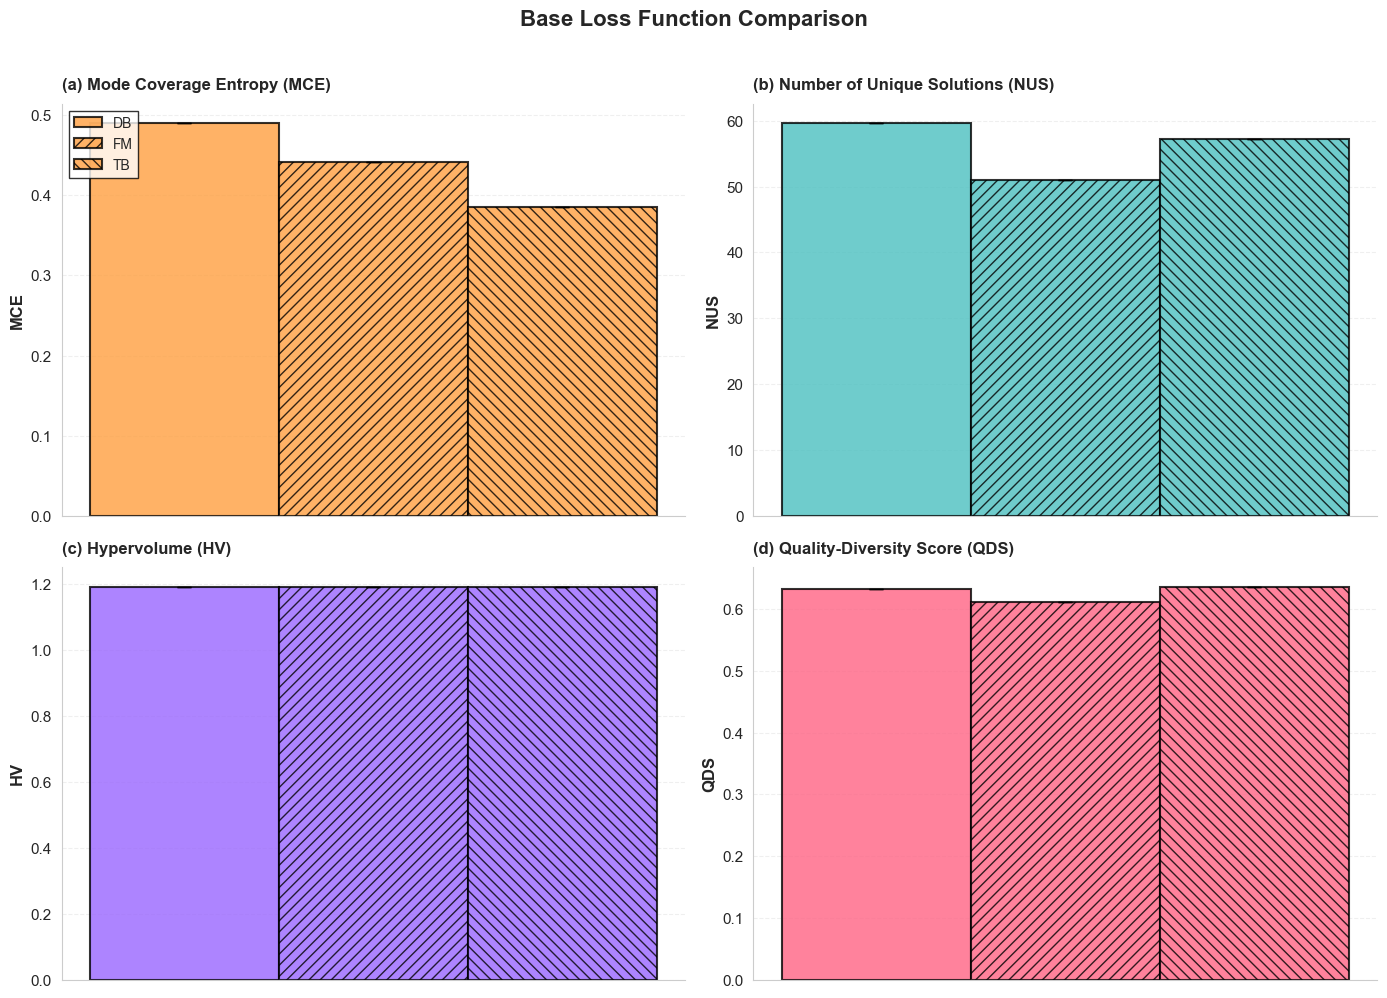

In [10]:
# Visualize base loss comparison
if len(base_df) > 0:
    # Select top 4 metrics for visualization
    plot_metrics = ['mce', 'num_unique_solutions', 'hypervolume', 'qds']
    plot_metrics = [m for m in plot_metrics if m in available_metrics]
    
    # Metric labels and colors (matching the reference style)
    metric_config = {
        'mce': {
            'label': 'Mode Coverage Entropy (MCE)',
            'color': '#FF9F40',  # Orange
            'ylabel': 'MCE'
        },
        'num_unique_solutions': {
            'label': 'Number of Unique Solutions (NUS)',
            'color': '#4BC0C0',  # Teal
            'ylabel': 'NUS'
        },
        'hypervolume': {
            'label': 'Hypervolume (HV)',
            'color': '#9966FF',  # Purple
            'ylabel': 'HV'
        },
        'qds': {
            'label': 'Quality-Diversity Score (QDS)',
            'color': '#FF6384',  # Pink/Red
            'ylabel': 'QDS'
        },
        'tds': {
            'label': 'Trajectory Diversity Score (TDS)',
            'color': '#36A2EB',  # Blue
            'ylabel': 'TDS'
        },
        'pfs': {
            'label': 'Pareto Front Smoothness (PFS)',
            'color': '#4BC653',  # Green
            'ylabel': 'PFS'
        }
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Base Loss Function Comparison', fontsize=16, fontweight='bold', y=0.995)
    axes = axes.flatten()
    
    # Define loss types and their styles
    loss_types = sorted(base_df['loss_type'].unique())
    loss_labels = {
        'trajectory_balance': 'TB',
        'detailed_balance': 'DB',
        'flow_matching': 'FM'
    }
    
    # Hatching patterns for each loss type
    hatching_patterns = ['', '///', '\\\\\\']
    
    # Metrics where lower is better
    lower_is_better = ['pfs']
    
    for idx, metric in enumerate(plot_metrics):
        ax = axes[idx]
        
        # Get metric configuration
        config = metric_config.get(metric, {
            'label': metric.upper(),
            'color': '#999999',
            'ylabel': metric.upper()
        })
        
        # Prepare data for grouped bars
        metric_data = []
        for loss_type in loss_types:
            values = base_df[base_df['loss_type'] == loss_type][metric].values
            if len(values) > 0:
                metric_data.append({
                    'loss': loss_type,
                    'mean': np.mean(values),
                    'std': np.std(values) if len(values) > 1 else 0
                })
        
        # Create grouped bar chart
        x = np.arange(1)  # Single group (all base losses together)
        width = 0.25  # Width of each bar
        
        for i, data in enumerate(metric_data):
            offset = (i - len(metric_data)/2 + 0.5) * width
            bars = ax.bar(x + offset, data['mean'], width, 
                         yerr=data['std'],
                         label=loss_labels.get(data['loss'], data['loss']),
                         color=config['color'],
                         alpha=0.8,
                         edgecolor='black',
                         linewidth=1.5,
                         hatch=hatching_patterns[i],
                         capsize=5,
                         error_kw={'linewidth': 1.5})
        
        # Styling
        ax.set_ylabel(config['ylabel'], fontsize=12, fontweight='bold')
        ax.set_title(f"({chr(97+idx)}) {config['label']}", 
                    fontsize=12, fontweight='bold', loc='left', pad=10)
        ax.set_xticks([])
        ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Add legend to first subplot
        if idx == 0:
            ax.legend(loc='upper left', fontsize=10, frameon=True, 
                     edgecolor='black', fancybox=False)
    
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig(output_dir / 'base_loss_comparison.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / 'base_loss_comparison.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_dir / 'base_loss_comparison.pdf'}")
    plt.show()

## 4. SubTrajectory Balance (SubTB) Variants

Compare different λ values for SubTB: 0.5, 0.9, 0.95

In [11]:
# Filter SubTB experiments
subtb_df = df[df['loss_category'] == 'subtb'].copy()

if len(subtb_df) > 0:
    print(f"SubTB experiments: {len(subtb_df)}")
    print(f"Variants: {subtb_df['loss_type'].unique()}")
    
    # Summary statistics - focus on key metrics
    metrics_to_summarize = key_metrics + ['final_loss']
    metrics_to_summarize = [m for m in metrics_to_summarize if m in subtb_df.columns]
    
    subtb_summary = subtb_df.groupby('loss_type')[metrics_to_summarize].agg(['mean', 'std', 'count'])
    subtb_summary.to_csv(output_dir / 'subtb_variants_summary.csv')
    print(f"\n✓ Saved: {output_dir / 'subtb_variants_summary.csv'}")
    
    # Display summary
    print("\n📊 SubTB Variant Performance:")
    display(subtb_summary.round(4))
    
    # Best variant per metric
    print("\n🏆 Best SubTB Variant per Metric:")
    # Metrics where lower is better
    lower_is_better = ['pfs']
    
    for metric in key_metrics[:8]:  # Top 8 key metrics
        if (metric, 'mean') in subtb_summary.columns:
            if metric in lower_is_better:
                best_variant = subtb_summary[(metric, 'mean')].idxmin()
                direction = "(lower is better)"
            else:
                best_variant = subtb_summary[(metric, 'mean')].idxmax()
                direction = "(higher is better)"
            best_value = subtb_summary.loc[best_variant, (metric, 'mean')]
            print(f"  {metric.upper():20s} {direction:20s}: {best_variant} ({best_value:.4f})")
else:
    print("⚠ No SubTB experiments found")

SubTB experiments: 3
Variants: ['subtrajectory_balance_05' 'subtrajectory_balance_09'
 'subtrajectory_balance_095']

✓ Saved: results/ablations/loss/report/subtb_variants_summary.csv

📊 SubTB Variant Performance:


mce           num_unique_solutions            \
                             mean std count                 mean std count   
loss_type                                                                    
subtrajectory_balance_05   0.4525 NaN     1                 59.2 NaN     1   
subtrajectory_balance_09   0.5347 NaN     1                 60.0 NaN     1   
subtrajectory_balance_095  0.5186 NaN     1                 59.6 NaN     1   

                          avg_pairwise_distance           hypervolume  ...  \
                                           mean std count        mean  ...   
loss_type                                                              ...   
subtrajectory_balance_05                 0.4814 NaN     1      1.1908  ...   
subtrajectory_balance_09                 0.4750 NaN     1      1.1909  ...   
subtrajectory_balance_095                0.4834 NaN     1      1.1921  ...   

                                    pfs               qds            \
                          count    mean std count    mean std count   
loss_type                                                             
subtrajectory_balance_05      1  0.0063 NaN     1  0.6379 NaN     1   
subtrajectory_balance_09      1  0.0156 NaN     1  0.6358 NaN     1   
subtrajectory_balance_095     1  0.0077 NaN     1  0.6385 NaN     1   

                          final_loss            
                                mean std count  
loss_type                                       
subtrajectory_balance_05      0.0011 NaN     1  
subtrajectory_balance_09      0.0011 NaN     1  
subtrajectory_balance_095     0.0015 NaN     1  

[3 rows x 21 columns]


🏆 Best SubTB Variant per Metric:
  MCE                  (higher is better)  : subtrajectory_balance_09 (0.5347)
  NUM_UNIQUE_SOLUTIONS (higher is better)  : subtrajectory_balance_09 (60.0000)
  AVG_PAIRWISE_DISTANCE (higher is better)  : subtrajectory_balance_095 (0.4834)
  HYPERVOLUME          (higher is better)  : subtrajectory_balance_095 (1.1921)
  PFS                  (lower is better)   : subtrajectory_balance_05 (0.0063)
  QDS                  (higher is better)  : subtrajectory_balance_095 (0.6385)


✓ Saved: results/ablations/loss/report/subtb_variants_comparison.pdf


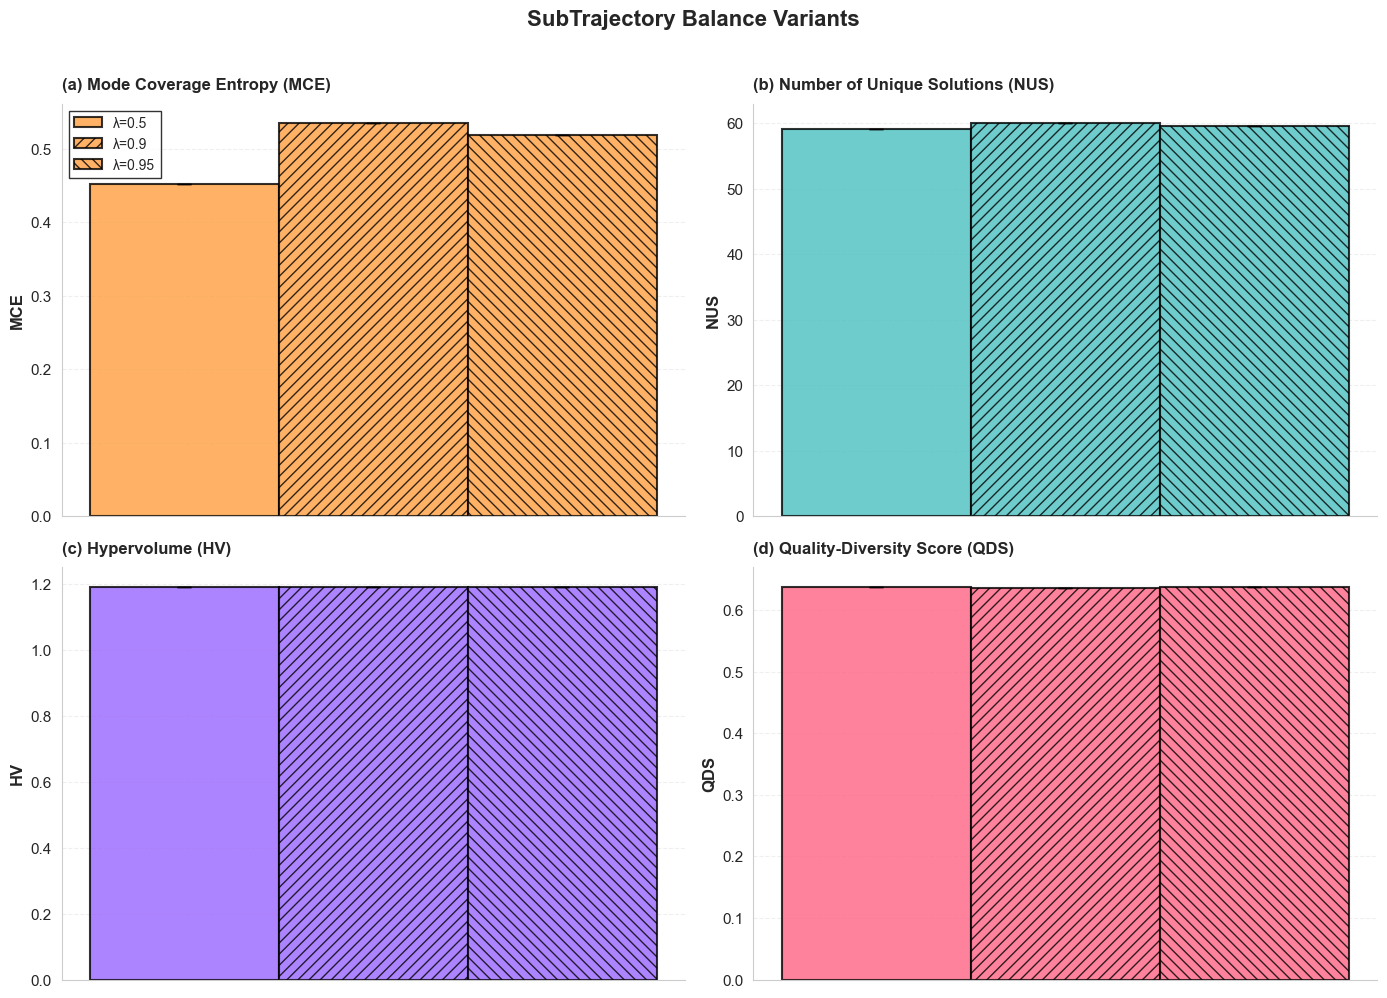

In [12]:
# Visualize SubTB variants
if len(subtb_df) > 0:
    # Select top 4 metrics
    plot_metrics = ['mce', 'num_unique_solutions', 'hypervolume', 'qds']
    plot_metrics = [m for m in plot_metrics if m in available_metrics]
    
    # Metric labels and colors (matching reference style)
    metric_config = {
        'mce': {
            'label': 'Mode Coverage Entropy (MCE)',
            'color': '#FF9F40',  # Orange
            'ylabel': 'MCE'
        },
        'num_unique_solutions': {
            'label': 'Number of Unique Solutions (NUS)',
            'color': '#4BC0C0',  # Teal
            'ylabel': 'NUS'
        },
        'hypervolume': {
            'label': 'Hypervolume (HV)',
            'color': '#9966FF',  # Purple
            'ylabel': 'HV'
        },
        'qds': {
            'label': 'Quality-Diversity Score (QDS)',
            'color': '#FF6384',  # Pink/Red
            'ylabel': 'QDS'
        }
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('SubTrajectory Balance Variants', fontsize=16, fontweight='bold', y=0.995)
    axes = axes.flatten()
    
    # Define SubTB variants and their styles
    loss_types = sorted(subtb_df['loss_type'].unique())
    loss_labels = {
        'subtrajectory_balance_05': 'λ=0.5',
        'subtrajectory_balance_09': 'λ=0.9',
        'subtrajectory_balance_095': 'λ=0.95'
    }
    
    # Hatching patterns for each variant
    hatching_patterns = ['', '///', '\\\\\\']
    
    for idx, metric in enumerate(plot_metrics):
        ax = axes[idx]
        
        # Get metric configuration
        config = metric_config.get(metric, {
            'label': metric.upper(),
            'color': '#999999',
            'ylabel': metric.upper()
        })
        
        # Prepare data for grouped bars
        metric_data = []
        for loss_type in loss_types:
            values = subtb_df[subtb_df['loss_type'] == loss_type][metric].values
            if len(values) > 0:
                metric_data.append({
                    'loss': loss_type,
                    'mean': np.mean(values),
                    'std': np.std(values) if len(values) > 1 else 0
                })
        
        # Create grouped bar chart
        x = np.arange(1)  # Single group
        width = 0.25  # Width of each bar
        
        for i, data in enumerate(metric_data):
            offset = (i - len(metric_data)/2 + 0.5) * width
            bars = ax.bar(x + offset, data['mean'], width,
                         yerr=data['std'],
                         label=loss_labels.get(data['loss'], data['loss']),
                         color=config['color'],
                         alpha=0.8,
                         edgecolor='black',
                         linewidth=1.5,
                         hatch=hatching_patterns[i],
                         capsize=5,
                         error_kw={'linewidth': 1.5})
        
        # Styling
        ax.set_ylabel(config['ylabel'], fontsize=12, fontweight='bold')
        ax.set_title(f"({chr(97+idx)}) {config['label']}", 
                    fontsize=12, fontweight='bold', loc='left', pad=10)
        ax.set_xticks([])
        ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Add legend to first subplot
        if idx == 0:
            ax.legend(loc='upper left', fontsize=10, frameon=True,
                     edgecolor='black', fancybox=False)
    
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig(output_dir / 'subtb_variants_comparison.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / 'subtb_variants_comparison.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_dir / 'subtb_variants_comparison.pdf'}")
    plt.show()

NameError: name 'legend_elements' is not defined

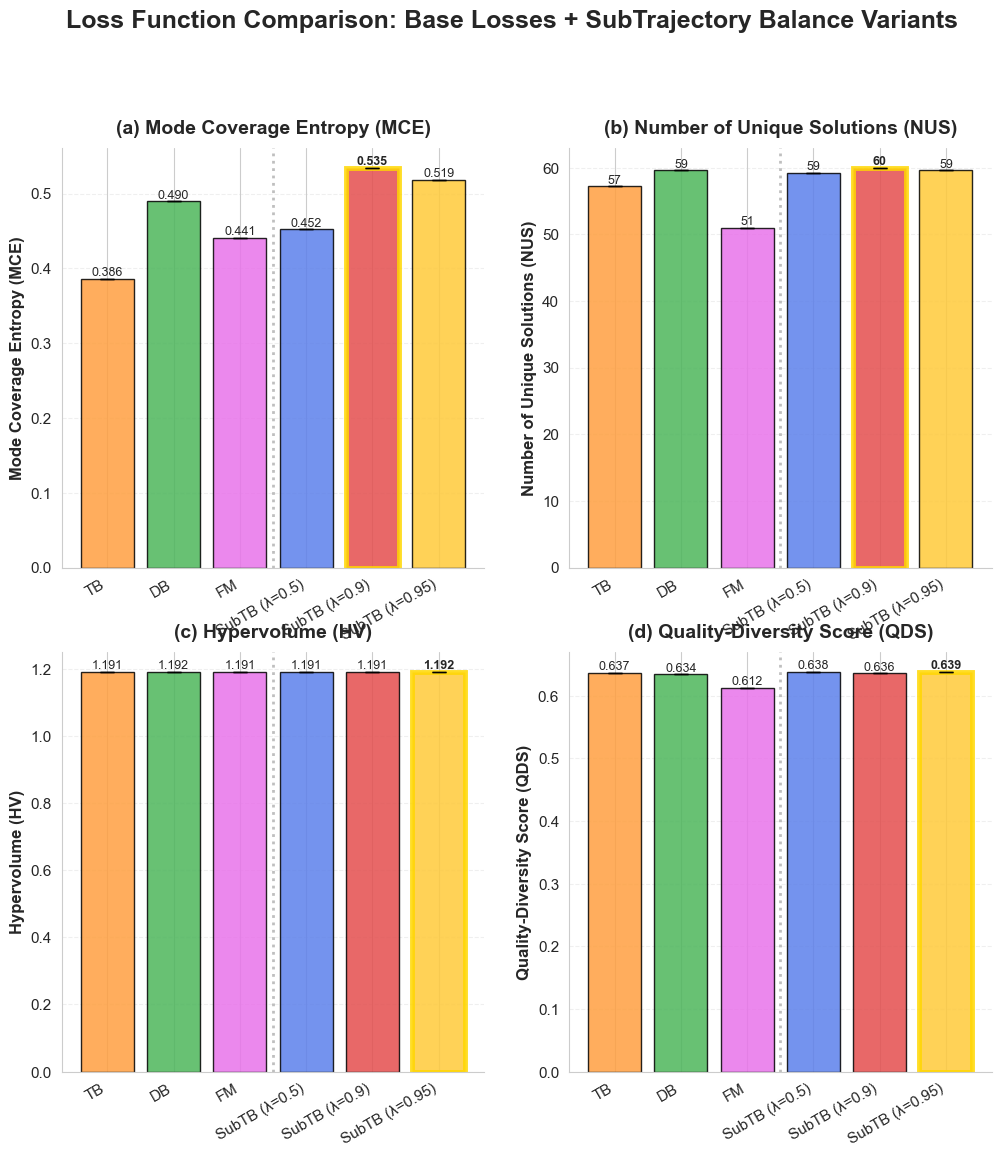

In [ ]:

# Create combined figure for paper: Base Losses + SubTB Variants
if len(base_df) > 0 and len(subtb_df) > 0:
    # Combine base and subtb dataframes
    combined_df = pd.concat([base_df, subtb_df], ignore_index=True)
    
    # Top 4 metrics: 3 diversity metrics + 1 quality metric for comprehensive loss evaluation
    plot_metrics = ['mce', 'num_unique_solutions', 'hypervolume', 'qds']
    plot_metrics = [m for m in plot_metrics if m in available_metrics]
    
    # Metric labels for publication
    metric_labels = {
        'mce': 'Mode Coverage Entropy (MCE)',
        'num_unique_solutions': 'Number of Unique Solutions (NUS)',
        'hypervolume': 'Hypervolume (HV)',
        'qds': 'Quality-Diversity Score (QDS)'
    }
    
    # Metrics where lower is better
    # lower_is_better = ['pfs']
    
    # Create 2x2 subplot figure
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    fig.suptitle('Loss Function Comparison: Base Losses + SubTrajectory Balance Variants',
                fontsize=18, fontweight='bold', y=0.995)
    axes = axes.flatten()
    
    # Define loss ordering and labels
    loss_order = [
        'trajectory_balance',
        'detailed_balance', 
        'flow_matching',
        'subtrajectory_balance_05',
        'subtrajectory_balance_09',
        'subtrajectory_balance_095'
    ]
    
    loss_labels = {
        'trajectory_balance': 'TB',
        'detailed_balance': 'DB',
        'flow_matching': 'FM',
        'subtrajectory_balance_05': 'SubTB (λ=0.5)',
        'subtrajectory_balance_09': 'SubTB (λ=0.9)',
        'subtrajectory_balance_095': 'SubTB (λ=0.95)'
    }
    
    # Color scheme: Base losses in blues, SubTB in purples/greens
    loss_colors = {
        'trajectory_balance': '#FF9F40',      # Blue
        'detailed_balance': "#4DB65B",        # Dark blue
        'flow_matching': "#E873EA",           # Light blue
        'subtrajectory_balance_05': "#5C80EB",   # Purple
        'subtrajectory_balance_09': "#E44E4E",   # Green
        'subtrajectory_balance_095': '#FFCA3A'  # Yellow
    }
    
    for idx, metric in enumerate(plot_metrics):
        ax = axes[idx]
        
        # Prepare data in specified order
        plot_data = []
        labels = []
        colors = []
        
        for loss_type in loss_order:
            if loss_type in combined_df['loss_type'].values:
                values = combined_df[combined_df['loss_type'] == loss_type][metric].values
                if len(values) > 0:
                    plot_data.append(values)
                    labels.append(loss_labels[loss_type])
                    colors.append(loss_colors[loss_type])
        
        # Calculate means and stds
        means = [np.mean(d) for d in plot_data]
        stds = [np.std(d) if len(d) > 1 else 0 for d in plot_data]
        
        # Create bar plot
        x_pos = np.arange(len(labels))
        bars = ax.bar(x_pos, means, yerr=stds, capsize=5, 
                    color=colors, alpha=0.85,
                    edgecolor='black', linewidth=1.0)
        
        # Highlight best performer with gold border (lower for PFS, higher for others)
        if metric in lower_is_better:
            best_idx = np.argmin(means)
        else:
            best_idx = np.argmax(means)
        
        bars[best_idx].set_edgecolor('gold')
        bars[best_idx].set_linewidth(3.5)
        
        # Add value labels on top of bars
        for i, (bar, mean) in enumerate(zip(bars, means)):
            height = bar.get_height()
            label_y = height + stds[i] if i == best_idx else height
            # Format: show integer for num_unique_solutions, decimals for others
            if metric == 'num_unique_solutions':
                label_text = f'{int(mean)}'
            else:
                label_text = f'{mean:.3f}'
            ax.text(bar.get_x() + bar.get_width()/2., label_y,
                label_text,
                ha='center', va='bottom', fontsize=9,
                fontweight='bold' if i == best_idx else 'normal')
        
        # Styling
        ax.set_xticks(x_pos)
        ax.set_xticklabels(labels, rotation=30, ha='right', fontsize=11)
        ax.set_ylabel(metric_labels.get(metric, metric.upper()), 
                    fontsize=12, fontweight='bold')
        ax.set_title(f'({chr(97+idx)}) {metric_labels.get(metric, metric.upper())}',
                    fontsize=14, fontweight='bold', pad=10)
        ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Add separator line between base and subtb
        ax.axvline(x=2.5, color='gray', linestyle=':', linewidth=2, alpha=0.5)
    legend_elements = []
    for loss_type in loss_order:
        if loss_type in combined_df['loss_type'].values:
            legend_elements.append(
                plt.Line2D([0], [0], marker='o', color='w', label=loss_labels[loss_type],
                        markerfacecolor=loss_colors[loss_type], markersize=10)
            )
    fig.legend(handles=legend_elements, loc='lower center', 
            ncol=2, fontsize=12, frameon=True, 
            bbox_to_anchor=(0.5, -0.02))
    
    plt.tight_layout(rect=[0, 0.02, 1, 0.98])
    
    # Save with high quality for paper
    plt.savefig(output_dir / 'loss_ablation_combined_paper_figure.pdf', 
                dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / 'loss_ablation_combined_paper_figure.png', 
                dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_dir / 'loss_ablation_combined_paper_figure.pdf'}")
    print(f"✓ Saved: {output_dir / 'loss_ablation_combined_paper_figure.png'}")
    plt.show()
    
    # Print summary statistics
    print("\n📊 Combined Loss Function Performance Summary:")
    print("="*80)
    for metric in plot_metrics:
        print(f"\n{metric_labels.get(metric, metric.upper())}:")
        print("-"*80)
        for loss_type in loss_order:
            if loss_type in combined_df['loss_type'].values:
                value = combined_df[combined_df['loss_type'] == loss_type][metric].values[0]
                # Check if this is the best value
                all_values = [combined_df[combined_df['loss_type'] == lt][metric].values[0] 
                            for lt in loss_order if lt in combined_df['loss_type'].values]
                if metric in lower_is_better:
                    is_best = value == min(all_values)
                else:
                    is_best = value == max(all_values)
                marker = ' ⭐' if is_best else ''
                # Format: integer for num_unique_solutions, float for others
                if metric == 'num_unique_solutions':
                    print(f"  {loss_labels[loss_type]:20s}: {int(value):8d}{marker}")
                else:
                    print(f"  {loss_labels[loss_type]:20s}: {value:8.4f}{marker}")
else:
    print("⚠ Need both base and SubTB data for combined figure")

In [ ]:
# Create comprehensive comparison plot - Top 6 loss functions
top_6_losses = [loss for loss, _ in top_losses[:6]]
top_df = df[df['loss_type'].isin(top_6_losses)].copy()

if len(top_df) > 0:
    # Select top 4 key metrics for visualization
    plot_metrics = ['mce', 'num_unique_solutions', 'hypervolume', 'qds']
    plot_metrics = [m for m in plot_metrics if m in available_metrics]
    
    # Metric labels and colors (matching reference style)
    metric_config = {
        'mce': {
            'label': 'Mode Coverage Entropy (MCE)',
            'color': '#FF9F40',  # Orange
            'ylabel': 'MCE'
        },
        'num_unique_solutions': {
            'label': 'Number of Unique Solutions (NUS)',
            'color': '#4BC0C0',  # Teal
            'ylabel': 'NUS'
        },
        'hypervolume': {
            'label': 'Hypervolume (HV)',
            'color': '#9966FF',  # Purple
            'ylabel': 'HV'
        },
        'qds': {
            'label': 'Quality-Diversity Score (QDS)',
            'color': '#FF6384',  # Pink/Red
            'ylabel': 'QDS'
        }
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Top 6 Loss Functions - Comprehensive Comparison', 
                 fontsize=16, fontweight='bold', y=0.995)
    axes = axes.flatten()
    
    # Define loss labels with shortened names
    loss_labels = {}
    for loss_type in top_6_losses:
        label = loss_type.replace('subtrajectory_balance', 'SubTB')
        label = label.replace('trajectory_balance', 'TB')
        label = label.replace('detailed_balance', 'DB')
        label = label.replace('flow_matching', 'FM')
        label = label.replace('_095', ' 0.95')
        label = label.replace('_09', ' 0.9')
        label = label.replace('_05', ' 0.5')
        label = label.replace('_', ' ')
        loss_labels[loss_type] = label
    
    # Hatching patterns (cycle through if more than 6)
    hatching_patterns = ['', '///', '\\\\\\', 'xxx', '+++', '...']
    
    for idx, metric in enumerate(plot_metrics):
        ax = axes[idx]
        
        # Get metric configuration
        config = metric_config.get(metric, {
            'label': metric.upper(),
            'color': '#999999',
            'ylabel': metric.upper()
        })
        
        # Prepare data for grouped bars
        metric_data = []
        for loss_type in top_6_losses:
            loss_df = top_df[top_df['loss_type'] == loss_type]
            if len(loss_df) > 0:
                values = loss_df[metric].values
                metric_data.append({
                    'loss': loss_type,
                    'mean': np.mean(values),
                    'std': np.std(values) if len(values) > 1 else 0
                })
        
        # Create grouped bar chart
        x = np.arange(1)  # Single group
        width = 0.12  # Narrower bars for 6 losses
        
        for i, data in enumerate(metric_data):
            offset = (i - len(metric_data)/2 + 0.5) * width
            bars = ax.bar(x + offset, data['mean'], width,
                         yerr=data['std'],
                         label=loss_labels.get(data['loss'], data['loss']),
                         color=config['color'],
                         alpha=0.8,
                         edgecolor='black',
                         linewidth=1.2,
                         hatch=hatching_patterns[i % len(hatching_patterns)],
                         capsize=4,
                         error_kw={'linewidth': 1.2})
        
        # Styling
        ax.set_ylabel(config['ylabel'], fontsize=12, fontweight='bold')
        ax.set_title(f"({chr(97+idx)}) {config['label']}", 
                    fontsize=12, fontweight='bold', loc='left', pad=10)
        ax.set_xticks([])
        ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Add legend to first subplot (smaller font due to 6 items)
        if idx == 0:
            ax.legend(loc='upper left', fontsize=8, frameon=True,
                     edgecolor='black', fancybox=False, ncol=2)
    
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig(output_dir / 'top_losses_comparison.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / 'top_losses_comparison.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_dir / 'top_losses_comparison.pdf'}")
    plt.show()

In [ ]:
# Create overall summary and rankings across ALL loss types
print("="*70)
print("OVERALL SUMMARY AND RANKINGS")
print("="*70)

# Create overall summary - group by loss_type and compute mean
overall_summary = df.groupby('loss_type')[available_metrics].mean()
print(f"\n✓ Created overall_summary with {len(overall_summary)} loss types")
print(f"  Loss types: {list(overall_summary.index)}")

# Create rankings for each metric
rankings = {}
lower_is_better = ['pfs']  # Metrics where lower values are better

for metric in available_metrics:
    if metric in overall_summary.columns:
        if metric in lower_is_better:
            # For metrics where lower is better, rank ascending
            rankings[metric] = overall_summary[[metric]].sort_values(metric, ascending=True)
        else:
            # For metrics where higher is better, rank descending
            rankings[metric] = overall_summary[[metric]].sort_values(metric, ascending=False)

print(f"✓ Created rankings for {len(rankings)} metrics")

# Save overall rankings to CSV
overall_rankings_df = pd.DataFrame()
for metric in available_metrics:
    if metric in rankings:
        rank_df = rankings[metric].reset_index()
        rank_df['rank'] = range(1, len(rank_df) + 1)
        rank_df['metric'] = metric
        overall_rankings_df = pd.concat([overall_rankings_df, rank_df], ignore_index=True)

overall_rankings_df.to_csv(output_dir / 'overall_loss_rankings.csv', index=False)
print(f"✓ Saved: {output_dir / 'overall_loss_rankings.csv'}")

print("\n📊 Overall Summary Preview (Key Metrics):")
preview_metrics = [m for m in key_metrics if m in overall_summary.columns][:5]
print(overall_summary[preview_metrics].round(4))

In [ ]:
# Compute average rank across all metrics
rank_scores = {}
for loss_type in overall_summary.index:
    ranks = []
    for metric in available_metrics:
        rank = rankings[metric].index.get_loc(loss_type) + 1
        ranks.append(rank)
    rank_scores[loss_type] = np.mean(ranks)

top_losses = sorted(rank_scores.items(), key=lambda x: x[1])[:10]

print("\n📊 Top 10 Loss Functions by Average Rank:")
print("="*70)
for i, (loss_type, avg_rank) in enumerate(top_losses, 1):
    category = df[df['loss_type'] == loss_type]['loss_category'].iloc[0] if len(df[df['loss_type'] == loss_type]) > 0 else 'unknown'
    print(f"  {i:2d}. {loss_type:35s} (Avg Rank: {avg_rank:5.2f}, Category: {category})")

In [ ]:
# Create comprehensive comparison plot - Top 6 loss functions
top_6_losses = [loss for loss, _ in top_losses[:6]]
top_df = df[df['loss_type'].isin(top_6_losses)].copy()

if len(top_df) > 0:
    # Select top 4 key metrics for visualization
    plot_metrics = ['mce', 'num_unique_solutions', 'hypervolume', 'qds']
    plot_metrics = [m for m in plot_metrics if m in available_metrics]
    
    # Metric labels
    metric_labels = {
        'mce': 'Mode Coverage Entropy\n(Diversity: higher is better)',
        'num_unique_solutions': 'Number of Unique Solutions\n(Uniqueness: higher is better)',
        'hypervolume': 'Hypervolume\n(Quality: higher is better)',
        'qds': 'Quality-Diversity Score\n(Composite: higher is better)',
        'pfs': 'Pareto Front Smoothness\n(Convergence: lower is better)',
        'avg_pairwise_distance': 'Avg Pairwise Distance\n(Spread: higher is better)'
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Top 6 Loss Functions - Comprehensive Comparison', 
                 fontsize=18, fontweight='bold', y=0.995)
    axes = axes.flatten()
    
    # Metrics where lower is better
    lower_is_better = ['pfs']
    
    for idx, metric in enumerate(plot_metrics):
        ax = axes[idx]
        
        plot_data = []
        labels = []
        categories = []
        
        for loss_type in top_6_losses:
            loss_df = top_df[top_df['loss_type'] == loss_type]
            if len(loss_df) > 0:
                values = loss_df[metric].values
                plot_data.append(values)
                # Shorten labels
                label = loss_type.replace('subtrajectory_balance', 'SubTB')
                label = label.replace('trajectory_balance', 'TB')
                label = label.replace('detailed_balance', 'DB')
                label = label.replace('flow_matching', 'FM')
                label = label.replace('_', ' ')
                labels.append(label)
                categories.append(loss_df['loss_category'].iloc[0])
        
        means = [np.mean(d) for d in plot_data]
        stds = [np.std(d) if len(d) > 1 else 0 for d in plot_data]
        
        # Color by category
        color_map = {'base': '#2E86AB', 'subtb': '#6A4C93', 'regularized': '#FF6B6B', 'other': '#95E1D3'}
        colors = [color_map.get(cat, '#999999') for cat in categories]
        
        bars = ax.bar(range(len(labels)), means, yerr=stds,
                      capsize=5, color=colors, alpha=0.8,
                      edgecolor='black', linewidth=1.5)
        
        # Highlight overall best (lower for PFS, higher for others)
        if metric in lower_is_better:
            best_idx = np.argmin(means)
        else:
            best_idx = np.argmax(means)
        bars[best_idx].set_edgecolor('gold')
        bars[best_idx].set_linewidth(3)
        
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=30, ha='right', fontsize=10)
        ax.set_ylabel(metric.upper(), fontsize=12, fontweight='bold')
        ax.set_title(metric_labels.get(metric, metric.upper()), fontsize=11, fontweight='bold')
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#2E86AB', label='Base Loss'),
        Patch(facecolor='#6A4C93', label='SubTB'),
        Patch(facecolor='#FF6B6B', label='Regularized'),
        Patch(facecolor='#95E1D3', label='Other')
    ]
    fig.legend(handles=legend_elements, loc='upper right', fontsize=11, frameon=True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig(output_dir / 'top_losses_comparison.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / 'top_losses_comparison.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_dir / 'top_losses_comparison.pdf'}")
    plt.show()

In [ ]:
# Generate comprehensive report
report = []
report.append("="*70)
report.append("LOSS ABLATION STUDY - COMPREHENSIVE REPORT")
report.append("="*70)
report.append("")
report.append("Key Metrics Used:")
report.append(f"  - Quality Metrics: {quality_metrics}")
report.append(f"  - Diversity Metrics: {diversity_metrics}")
report.append(f"  - Composite Metrics: {composite_metrics}")
report.append("")

# Metrics where lower is better
lower_is_better = ['pfs']

# Base loss summary
if len(base_df) > 0:
    report.append("## Base Loss Functions (TB, DB, FM)")
    report.append("-" * 70)
    metrics_to_report = key_metrics[:5]
    base_summary_data = base_df.groupby('loss_type')[[m for m in metrics_to_report if m in base_df.columns]].mean()
    for metric in metrics_to_report:
        if metric in base_summary_data.columns:
            if metric in lower_is_better:
                best_loss = base_summary_data[metric].idxmin()
                best_value = base_summary_data[metric].min()
                direction = "(lower is better)"
            else:
                best_loss = base_summary_data[metric].idxmax()
                best_value = base_summary_data[metric].max()
                direction = "(higher is better)"
            report.append(f"  Best {metric.upper()} {direction}: {best_loss} ({best_value:.4f})")
    report.append("")

# SubTB summary
if len(subtb_df) > 0:
    report.append("## SubTrajectory Balance Variants")
    report.append("-" * 70)
    metrics_to_report = key_metrics[:5]
    subtb_summary_data = subtb_df.groupby('loss_type')[[m for m in metrics_to_report if m in subtb_df.columns]].mean()
    for metric in metrics_to_report:
        if metric in subtb_summary_data.columns:
            if metric in lower_is_better:
                best_variant = subtb_summary_data[metric].idxmin()
                best_value = subtb_summary_data[metric].min()
                direction = "(lower is better)"
            else:
                best_variant = subtb_summary_data[metric].idxmax()
                best_value = subtb_summary_data[metric].max()
                direction = "(higher is better)"
            report.append(f"  Best {metric.upper()} {direction}: {best_variant} ({best_value:.4f})")
    report.append("")

report.append("="*70)
report.append("OVERALL RECOMMENDATIONS")
report.append("="*70)
report.append("")
report.append("Top 10 Loss Functions by Average Rank:")
report.append("  (Lower average rank = better overall performance across all metrics)")
for i, (loss_type, avg_rank) in enumerate(top_losses, 1):
    category = df[df['loss_type'] == loss_type]['loss_category'].iloc[0] if len(df[df['loss_type'] == loss_type]) > 0 else 'unknown'
    report.append(f"  {i:2d}. {loss_type:35s} (Avg Rank: {avg_rank:5.2f}, {category})")

report.append("")
report.append("Key Insights:")
report.append("  - Metrics are separated into Quality (HV, PFS) and Diversity (MCE, PMD, APD)")
report.append("  - Primary focus is on diversity metrics with quality as sanity check")
report.append("  - PFS (Pareto Front Smoothness) is ranked with lower values being better")
report.append("  - QDS (Quality-Diversity Score) combines both quality and diversity")
report.append("  - Review the generated CSVs for detailed statistics")
report.append("  - Compare PDF visualizations for metric-specific trends")
report.append("  - Consider trade-offs between convergence quality and diversity")
report.append("  - SubTB variants may offer good balance for diversity-focused tasks")
report.append("")
report.append("="*70)

# Print report
report_text = "\n".join(report)
print(report_text)

# Save report
with open(output_dir / 'comprehensive_report.txt', 'w') as f:
    f.write(report_text)

print(f"\n✓ Saved: {output_dir / 'comprehensive_report.txt'}")

## 6. Comprehensive Summary Report

In [ ]:
# Generate comprehensive report
report = []
report.append("="*70)
report.append("LOSS ABLATION STUDY - COMPREHENSIVE REPORT")
report.append("="*70)
report.append("")

# Base loss summary
if len(base_df) > 0:
    report.append("## Base Loss Functions (TB, DB, FM)")
    report.append("-" * 70)
    base_summary_data = base_df.groupby('loss_type')[available_metrics[:5]].mean()
    for metric in available_metrics[:5]:
        best_loss = base_summary_data[metric].idxmax()
        best_value = base_summary_data[metric].max()
        report.append(f"  Best {metric.upper()}: {best_loss} ({best_value:.4f})")
    report.append("")

# SubTB summary
if len(subtb_df) > 0:
    report.append("## SubTrajectory Balance Variants")
    report.append("-" * 70)
    subtb_summary_data = subtb_df.groupby('loss_type')[available_metrics[:5]].mean()
    for metric in available_metrics[:5]:
        best_variant = subtb_summary_data[metric].idxmax()
        best_value = subtb_summary_data[metric].max()
        report.append(f"  Best {metric.upper()}: {best_variant} ({best_value:.4f})")
    report.append("")

report.append("="*70)
report.append("OVERALL RECOMMENDATIONS")
report.append("="*70)
report.append("")
report.append("Top 10 Loss Functions by Average Rank:")
for i, (loss_type, avg_rank) in enumerate(top_losses, 1):
    category = df[df['loss_type'] == loss_type]['loss_category'].iloc[0] if len(df[df['loss_type'] == loss_type]) > 0 else 'unknown'
    report.append(f"  {i:2d}. {loss_type:35s} (Avg Rank: {avg_rank:5.2f}, {category})")

report.append("")
report.append("Key Insights:")
report.append("  - Review the generated CSVs for detailed statistics")
report.append("  - Compare PDF visualizations for metric-specific trends")
report.append("  - Consider trade-offs between training stability and diversity")
report.append("  - SubTB variants offer good balance for most metrics")
report.append("")
report.append("="*70)

# Print report
report_text = "\n".join(report)
print(report_text)

# Save report
with open(output_dir / 'comprehensive_report.txt', 'w') as f:
    f.write(report_text)

print(f"\n✓ Saved: {output_dir / 'comprehensive_report.txt'}")

In [ ]:
# List all generated files
print("\n📁 Generated Files:")
print("="*70)
generated_files = sorted(output_dir.glob('*'))
for file in generated_files:
    print(f"  ✓ {file.name}")

print(f"\nTotal: {len(generated_files)} files generated in {output_dir}")

## 7. Next Steps

Based on the analysis:

1. **Review the summary CSVs** for detailed statistics on each loss type
2. **Examine the visualizations** to understand metric-specific trends
3. **Compare base vs SubTB** to understand the trade-offs
4. **Select the best loss function** based on your optimization goals
5. **Consider stability** - some losses may be more stable during training

**Key Files:**
- `base_loss_summary.csv` - Base loss function results (TB, DB, FM)
- `subtb_variants_summary.csv` - SubTB variant comparison
- `overall_loss_rankings.csv` - Complete rankings across all losses
- `comprehensive_report.txt` - Text summary with recommendations
- `top_losses_comparison.pdf` - Visual comparison of top performers